# DL based approached for disparity estimation

## Using the Dataset
A good dataset is the backbone of any solution that’s based on Deep Learning, and the same is true even for depth estimation.

The most popular stereo dataset is called KITTI. Some other useful datasets are SceneFlow, Middlebury, and Holopix50K.

KITTI Datasets
A project of Karlsruhe Institute of Technology and the Toyota Technological Institute, KITTI  has set up a suite of sensors on cars that collect rich data for autonomous-driving cars. The sensor suite consists of

- Colored and gray channel stereo cameras
- A Velodyne-laser scanner, which provides accurate 3D information, in the form of raw point clouds
- A GPS-localization system

**KITTI 2012**
KITTI 2012, introduced in CVPR2012, is a stereo dataset consisting of static scenes captured with a stereo camera setup.

**KITTI 2015**
KITTI 2015, introduced in CVPR2015, is a stereo dataset with dynamic objects in the scene.

This post will focus on the KITTI 2015 Dataset.

**Using Networks for Disparity Estimation:**
We want to estimate the disparity from a stereo pair of rectified images, by dense-stereo matches. This can also be done by Deep Learning-based models. One of the initial solutions was Matching Cost Convolutional Neural Networks (MC-CNN)

## Using Networks for Disparity Estimation:
We want to estimate the disparity from a stereo pair of rectified images, by dense-stereo matches. This can also be done by Deep Learning-based models. One of the initial solutions was Matching Cost Convolutional Neural Networks (MC-CNN). Many more methods followed..

Two of the widely experimented ways are

### Direct Regression Methods
Direct regression methods try to estimate the per-pixel disparity from the input images directly without taking into account the geometric constraints in stereo matching. This is a fully data-driven approach that utilizes large U-shaped 2D-convolution networks. Not accounting for geometric constraints however places them behind volumetric methods, when it comes to performance.

### Volumetric Methods
Volumetric methods leverage the concept of **semi-global matching** and build a 4D-feature volume, by concatenating features from each disparity shift. It has four major components:

1. A feature net to extract features from the input images
2. A cost-volume module to concatenate the features extracted from the left and right images
3. A matching net to compute matching costs from the 4D-feature volume with 3D convolutions
4. The regression module to regress disparity

We will look at the most famous volumetric method for disparity estimation, the Pyramid Stereo Matching Network (PSMNet). While PSMNet is not the state-of-the-art network for stereo matching, most of the networks proposed for stereo matching in volumetric methods are inspired by PSMNet. That makes it a great starting point for network-based stereo matching. So let’s examine the architecture of PSMNet:

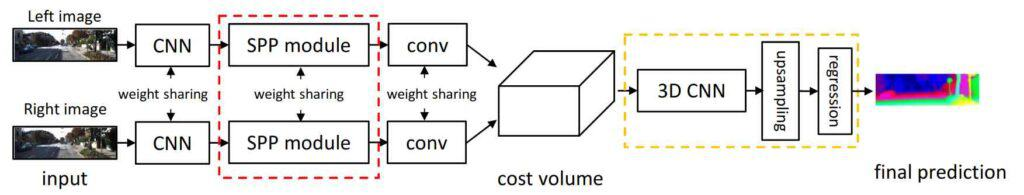

Architecture of PSMNet Showing its different modules

### 2D Feature Matching
The Convolutional Neural Network (CNN) helps extract features from the images, which can be edges or textures across the image. In PSMNet,

 CNN gives out the feature map, which is ¼ the input image size and summarizes the detected features in the input.
Applied to both the input images, these CNNs  share the same weights, so that similar features are extracted from both the images, which as you will see is important for the following steps.

[Code_Colab](https://colab.research.google.com/github/spmallick/learnopencv/blob/master/Disparity-Estimation-Using-Deep-Learning/PSMNet_Test_Example.ipynb)

###SPP Module :
The SPP (Spatial Pyramid Pooling) module extracts the feature map of different scales. The following figure explains the SPP module in detail.

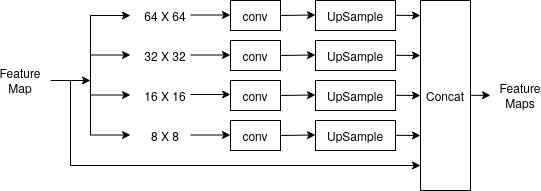


Diagram explaining SPP Module to extract feature maps at various scales

In the SPP module,

To get contextual information at various scales, the feature maps are filtered through average-pooling filters of four different  resolutions:
64X64
32X32
16X16
8X8
Then these maps are passed through a 1X1 convolution layer to reduce the dimensions.
Next,  the maps are upsampled to match the size of the original feature map
 Finally, these maps are concatenated along with the original feature map.

### Cost Volume :
After getting the feature maps from various scales, we want to combine the features from the images on the left as well as right. The Cost Volume Module then:

- Concatenates the features extracted from the left and right images
- Stores the distance between the features

This results in a 4D array of size: height × width × (max disparity + 1) × (feature sizes), which is called Cost Volume.

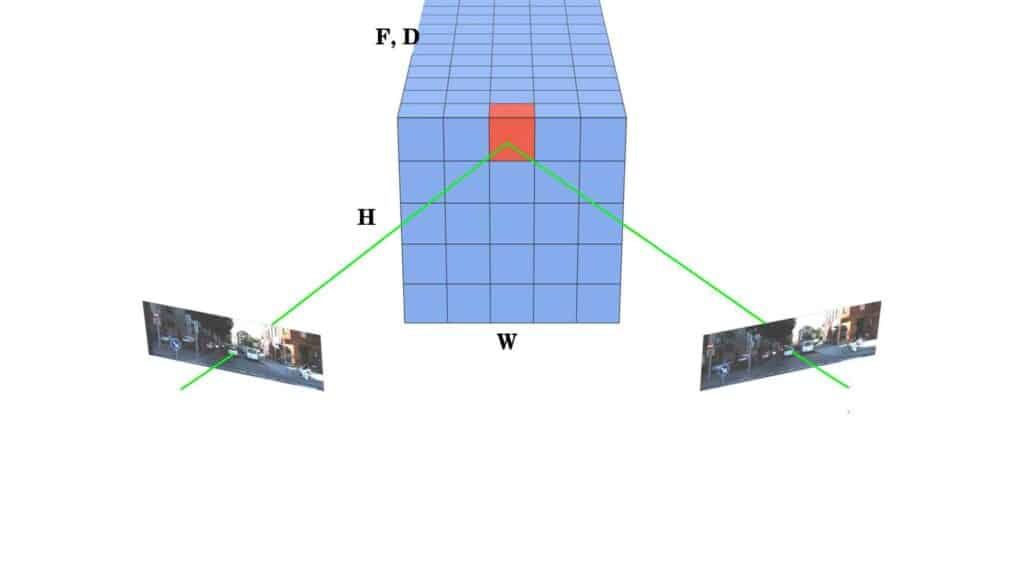

Diagram showing how the cost volume is constructed


Each voxel of the cost volume is the matching cost of corresponding features, projected from the left and right views. Computing the cost volume requires much calculation and memory. To know various cost-volume techniques, refer to this study. It also provides an optimized method for doing cost-volume estimation, which produces ‘dense’ 3d-cost volumes. Okay, let’s not linger more with the concept and check out the code for finding cost volume in PSMNet.

###3D CNN and Regression Module
From the Cost Volume Module, we get the 4D-cost volume, and now we want to concatenate the information, along the two dimensions:

disparity dimension (3rd dimension in 4D-cost volume)
spatial dimension (4th dimension of 4D cost volume)
To do this, we use the 3D CNN. PSMNet has two variations of 3D CNN architectures:

The first one is a basic architecture that uses 12 3x3x3 convolution layers, with skip connections, as shown below:

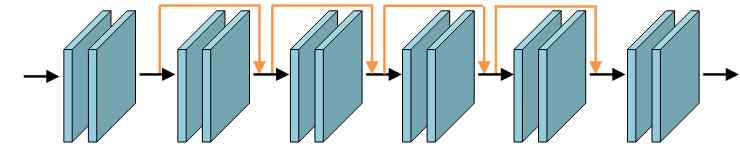

2. Because the basic architecture cannot exploit the contextual information,  the PSMNet also has an Encoder-Decoder based architecture variant called the stacked-hourglass architecture.

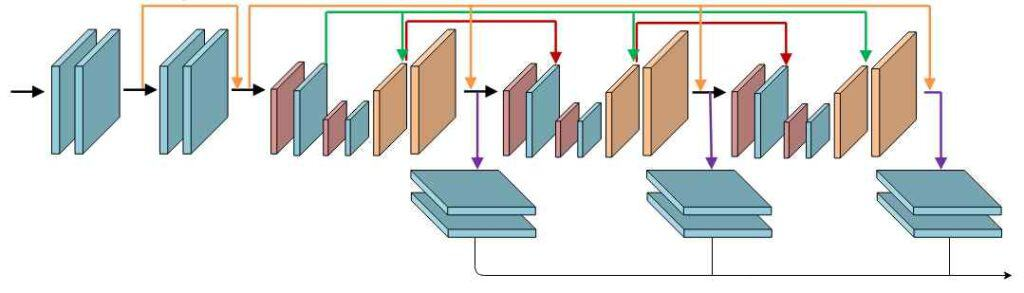


Network Architecture of stacked hourglass variant of 3D CNN Module

The output of 3D CNN is upsampled to the size of height x width x  (max disparity + 1) by  Interpolation. Trilinear interpolation is an upsampling method, which uses a distance-weighted average, of the nearest cell’s 3D features, to obtain the value of the newly-made cells.
After interpolation, we have a 3D-cost volume, height x width x (max disparity + 1), which has (max disparity + 1) disparity images of size height x width.
The probability along the disparity dimension is normalized, using the softmax operation.
The  normalized probability values are multiplied with the disparity to obtain the final disparity.
Keep in mind that the softmax is a logistic-regression function, and it is usually the last activation function used to normalize the output of the network, over a probability distribution. Its mathematical formula is:

\sigma (z)_i = \frac{e^{z_i}}{\sum_{j=1}^{Dmax}e^{z_i}}
This softmax is plugged into the weighted-disparity formula to get the disparity of the pixel, which is:

disparity = \sum_{j=1}^{Dmax} d.\sigma (c_j))
Softmax is a widely-studied function for networks and therefore has all the desired properties for network training like:

it is differentiable to backpropagate
is not discrete, hence produces smooth disparities
And finally, for the training part of the network, a loss function is needed to backpropagate the prediction error. A Smooth L1 loss is used over the L2 loss due to its wide acceptance in similar tasks. The Smooth L1 Loss for PSMNet looks like this:
Image showing formulas of Smooth L1 loss function
Image showing formulas of Smooth L1 loss function
The regression function outputs the final disparity map of the two input images, which however still needs to be converted to a depth map. The depth value is inversely proportional to the disparity values.  For a detailed explanation of how to get the depth map from the disparity map, please go back to our Depth Estimation post.

### References
[1] PSMNet : Chang, Jia-Ren and Chen, Yong-Sheng. Pyramid Stereo Matching Network, Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 2018

[2] LEANet : Cheng, Xuelian and Zhong, Yiran and Harandi, Mehrtash and Dai, Yuchao and Chang, Xiaojun and Li, Hongdong and Drummond, Tom and Ge, Zongyuan. Hierarchical Neural Architecture Search for Deep Stereo Matching

[3] MC-CNN : J. Zbontar and Y. LeCun. Stereo matching by training a convolutional neural network to compare image patches. Journal of Machine Learning Research, 17(1-32):2, 2016

[4] GCNet : A. Kendall, H. Martirosyan, S. Dasgupta, P. Henry,R. Kennedy, A. Bachrach, and A. Bry. End-to-end learning of geometry and context for deep stereo regression. In The IEEE International Conference on Computer Vision (ICCV), Oct 2017

https://colab.research.google.com/github/spmallick/learnopencv/blob/master/Disparity-Estimation-Using-Deep-Learning/PSMNet_Test_Example.ipynb